In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler

import modules.dataloaders as custom_dataloader
import modules.train_modul as train
import modules.models.custom_models as custom_models

In [2]:
dataloaders, dataset_sizes, class_names = custom_dataloader.dataload('files/dif_cats', 8)

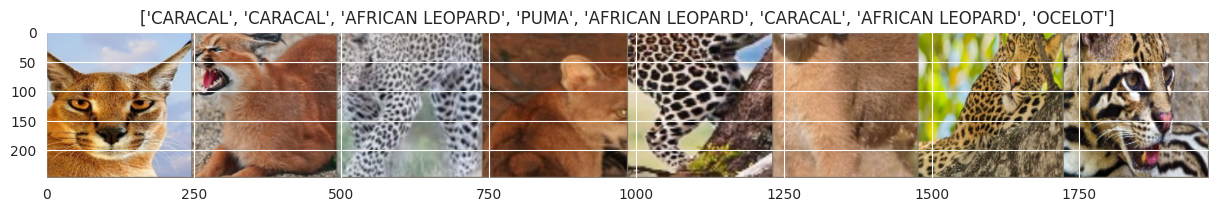

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(([0.485, 0.456, 0.406]))
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Train models

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 1) Custom model

In [34]:
custom_model_1 = custom_models.RNN_1(10)
custom_model_1.name = 'RNN_1'

custom_model_1 = custom_model_1.to(device)
loss_fn_1 = nn.CrossEntropyLoss()
opimizer_fn_1 = optim.Adam(custom_model_1.parameters(), lr=1e-4)
exp_lr_scheduler_1 = lr_scheduler.StepLR(opimizer_fn_1, step_size=20, gamma=0.1)

In [35]:
custom_model_1, losses_1, accuracy_1 = train.train_model(custom_model_1, loss_fn_1, opimizer_fn_1, exp_lr_scheduler_1, dataloaders, device, dataset_sizes, num_epochs=60)

Epoch::   0%|          | 0/60 [00:00<?, ?it/s]

Training time is 3 min 18 sec
Best accuracy is 0.83


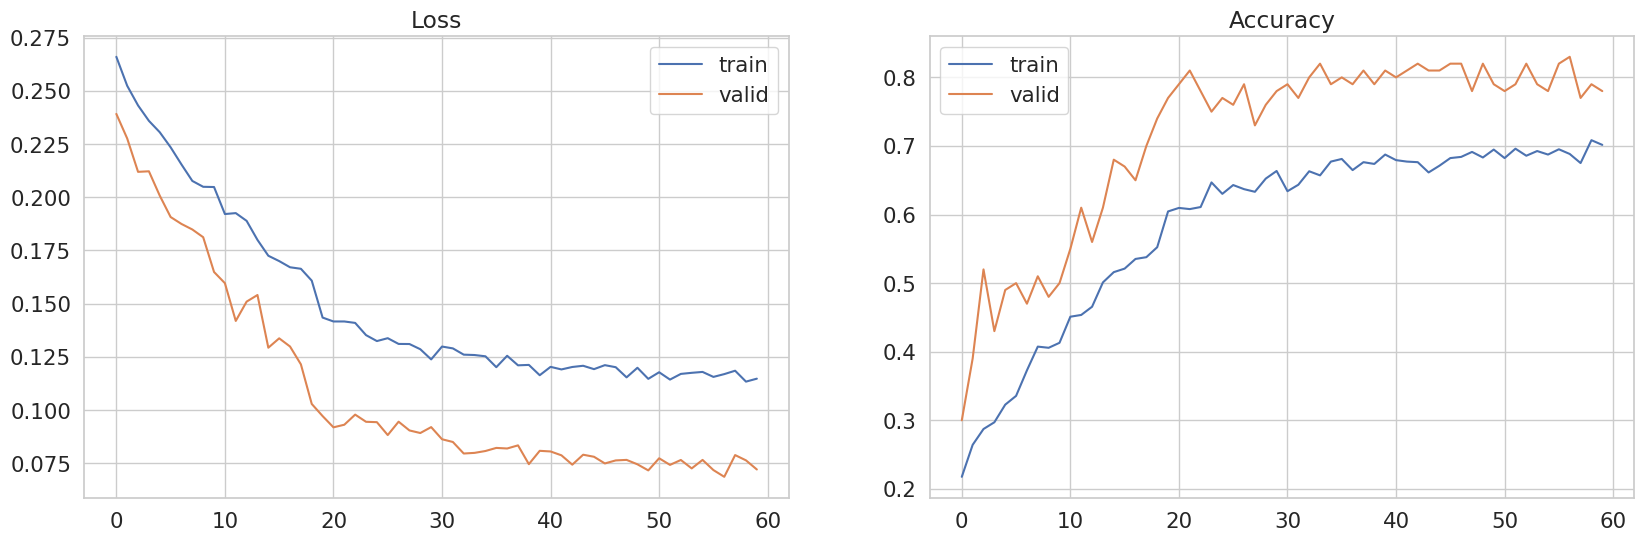

In [36]:
train.pic_losses(losses_1, accuracy_1, ['train', 'valid'])

In [37]:
print(f'Accuracy test {custom_model_1.name}: {round(train.evaluate(custom_model_1, dataloaders["valid"], device, dataset_sizes["valid"]), 4)}')

Accuracy test RNN_1: 0.78


### 2) AlexNet

In [9]:
model_alexnet = models.alexnet(pretrained=True)
model_alexnet.name = 'AlexNet'

/home/dmitriy/Classification_images/venv/bin/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dmitriy/Classification_images/venv/bin/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
num_layers = 5
train.freeze(model_alexnet, num_layers)

In [11]:
model_alexnet.classifier = nn.Sequential(nn.Dropout(p=0.5, inplace=False), nn.Linear(9216, 4096), nn.ReLU(), nn.Linear(4096, 4096), nn.ReLU(), nn.Linear(4096, 10))
model_alexnet = model_alexnet.to(device)
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.Adam(list(model_alexnet.features.parameters())[-num_layers:] + list(model_alexnet.classifier.parameters()), lr=1e-4)
exp_lr_scheduler_2 = lr_scheduler.StepLR(optimizer_2, step_size=7, gamma=0.1)

In [12]:
model_alexnet, losses_2, accuracy_2 = train.train_model(model_alexnet, loss_fn_2, optimizer_2, exp_lr_scheduler_2, dataloaders, device, dataset_sizes, num_epochs=30)

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

Training time is 2 min 53 sec
Best accuracy is 0.97


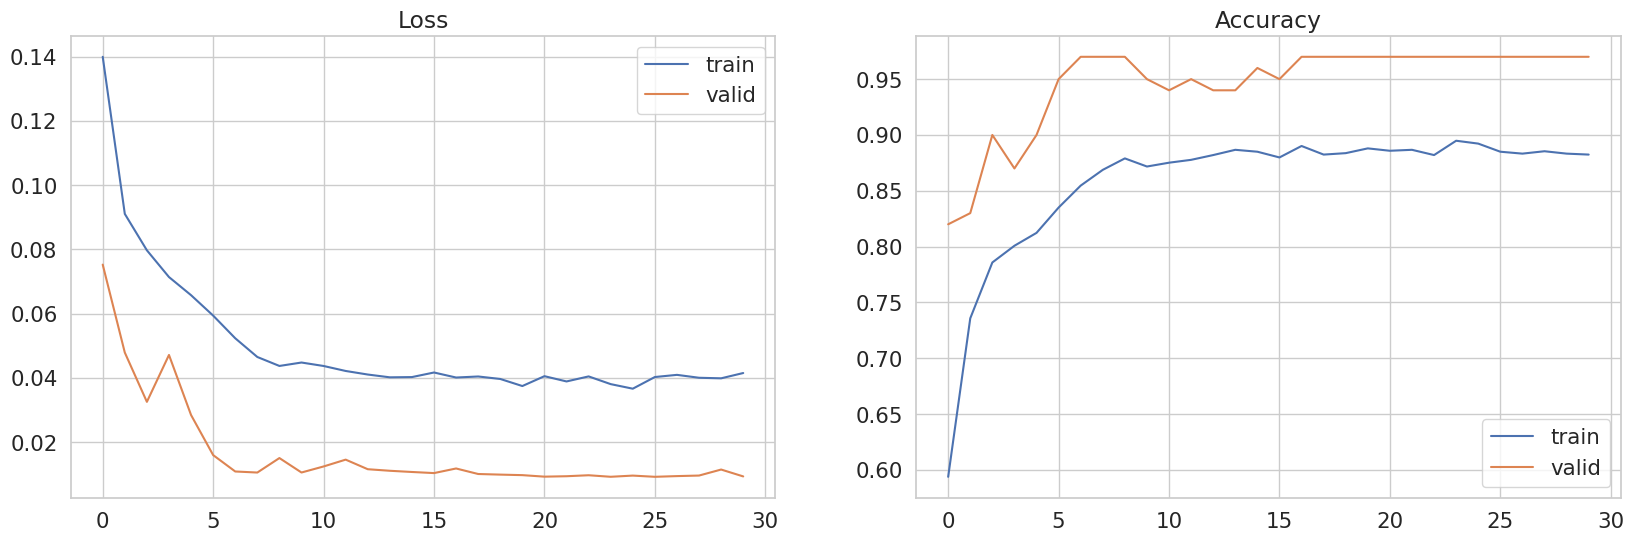

In [13]:
train.pic_losses(losses_2, accuracy_2, ['train', 'valid'])

In [14]:
print(f'Accuracy test {model_alexnet.name}: {round(train.evaluate(model_alexnet, dataloaders["valid"], device, dataset_sizes["valid"]), 4)}')

Accuracy test AlexNet: 0.97


In [15]:
torch.save(model_alexnet.state_dict(), f'modules/models/wights_models/{model_alexnet.name}.pth')

### 3) VGG-16

In [16]:
model_vgg = models.vgg16(pretrained=True)
model_vgg.name = 'VGG-16'

/home/dmitriy/Classification_images/venv/bin/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
num_layers = 5
train.freeze(model_vgg, num_layers)

In [18]:
model_vgg.classifier = nn.Sequential(nn.Linear(25088, 4096), nn.ReLU(), nn.Dropout(p=0.5, inplace=False), nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5, inplace=False), nn.Linear(4096, 10))
model_vgg = model_vgg.to(device)
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.Adam(list(model_vgg.features.parameters())[-num_layers:] + list(model_vgg.classifier.parameters()), lr=1e-4)
exp_lr_scheduler_3 = lr_scheduler.StepLR(optimizer_3, step_size=7, gamma=0.1)

In [19]:
model_vgg, losses_3, accuracy_3 = train.train_model(model_vgg, loss_fn_3, optimizer_3, exp_lr_scheduler_3, dataloaders, device, dataset_sizes, num_epochs=30)

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

Training time is 8 min 49 sec
Best accuracy is 0.98


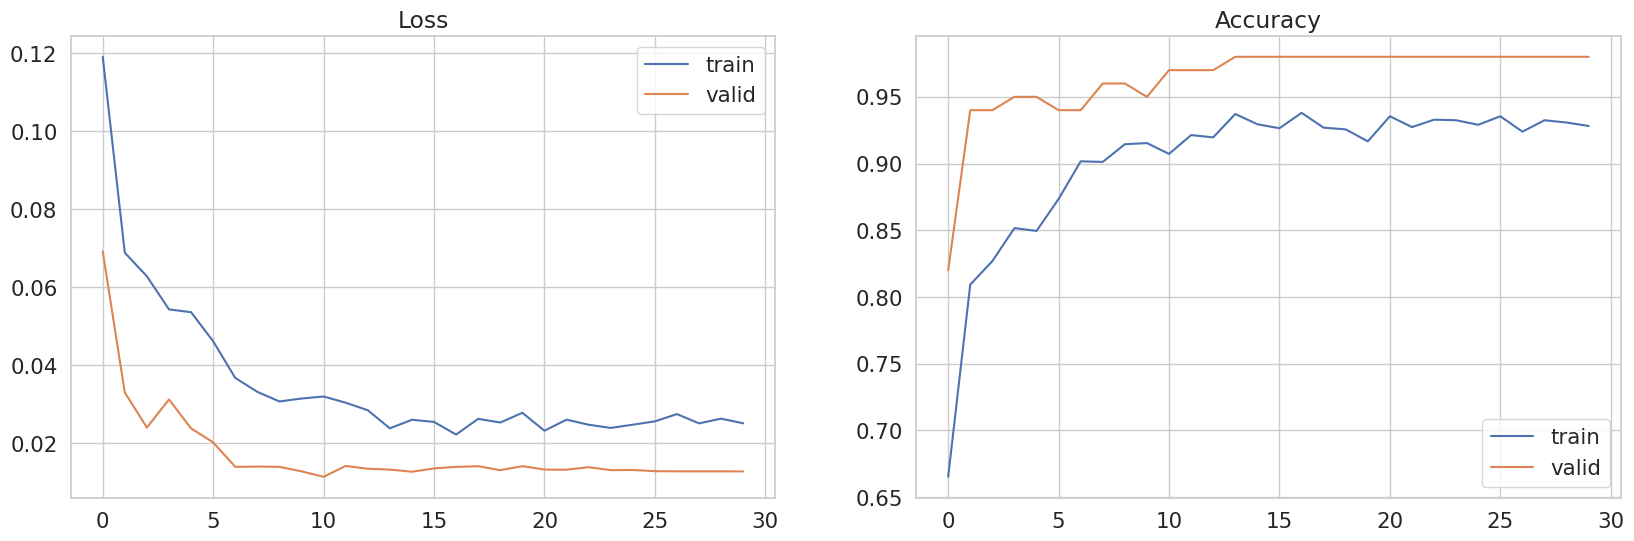

In [20]:
train.pic_losses(losses_3, accuracy_3, ['train', 'valid'])

In [21]:
print(f'Accuracy test {model_vgg.name}: {round(train.evaluate(model_vgg, dataloaders["valid"], device, dataset_sizes["valid"]), 4)}')

Accuracy test VGG-16: 0.98


In [22]:
torch.save(model_vgg.state_dict(), f'modules/models/wights_models/{model_vgg.name}.pth')

### 4) ResNet

In [23]:
model_resnet = models.resnet50(pretrained=True)
model_resnet.name = 'ResNet-50'

/home/dmitriy/Classification_images/venv/bin/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
for param in model_resnet.parameters():
    param.requires_grad = False
for param in model_resnet.layer4.parameters():
    param.requires_grad = True

In [25]:
model_resnet.fc = nn.Linear(2048, 10)

model_resnet = model_resnet.to(device)

loss_fn_4 = nn.CrossEntropyLoss()
optimizer_4 = optim.Adam(list(model_resnet.layer4.parameters()) + list(model_resnet.fc.parameters()), lr=1e-4)
exp_lr_scheduler_4 = lr_scheduler.StepLR(optimizer_4, step_size=7, gamma=0.1)

In [26]:
model_resnet, losses_4, accuracy_4 = train.train_model(model_resnet, loss_fn_4, optimizer_4, exp_lr_scheduler_4, dataloaders, device, dataset_sizes, num_epochs=30)

Epoch::   0%|          | 0/30 [00:00<?, ?it/s]

Training time is 3 min 53 sec
Best accuracy is 1.0


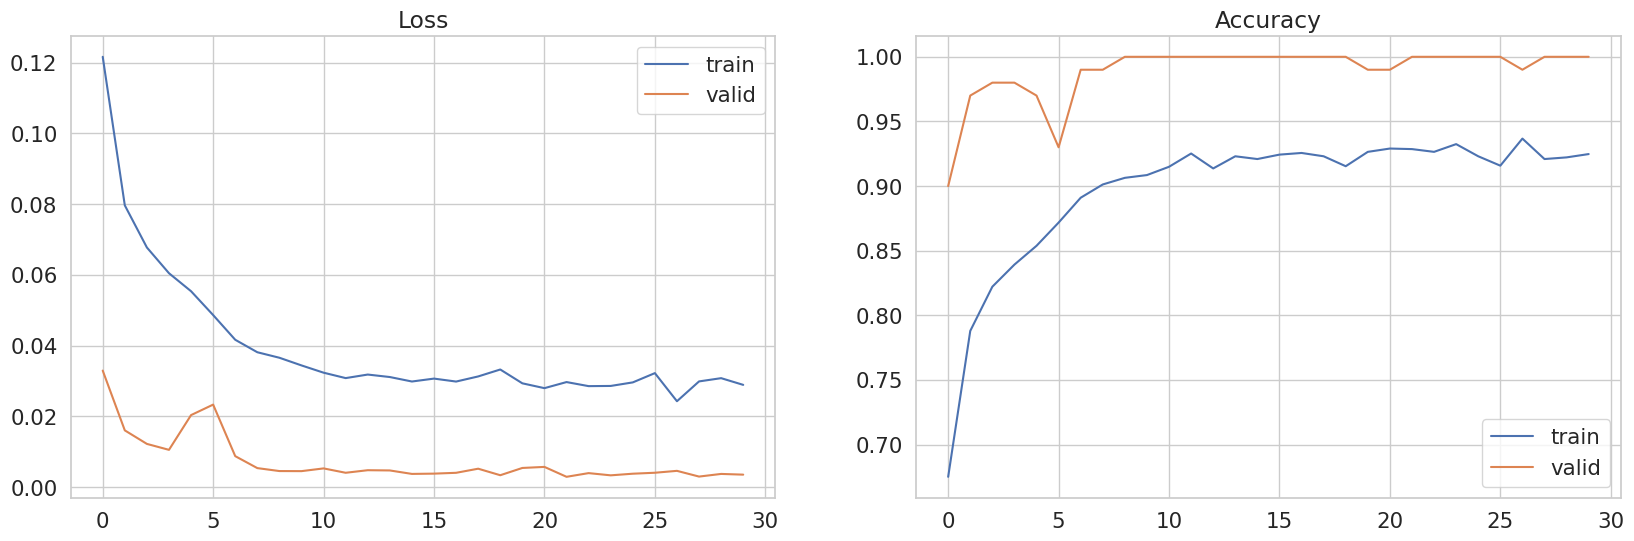

In [27]:
train.pic_losses(losses_4, accuracy_4, ['train', 'valid'])

In [28]:
print(f'Accuracy test {model_resnet.name}: {round(train.evaluate(model_resnet, dataloaders["valid"], device, dataset_sizes["valid"]), 4)}')

Accuracy test ResNet-50: 1.0


In [29]:
torch.save(model_resnet.state_dict(), f'modules/models/wights_models/{model_resnet.name}.pth')

# Statistics

In [38]:
arr = [
    {'name': custom_model_1.name,
     'losses': losses_1,
     'accuracy': accuracy_1,
     'model': custom_model_1
     },
    {'name': model_alexnet.name,
     'losses': losses_2,
     'accuracy': accuracy_2,
     'model': model_alexnet
     },
    {'name': model_vgg.name,
     'losses': losses_3,
     'accuracy': accuracy_3,
     'model': model_vgg
     },
    {'name': model_resnet.name,
     'losses': losses_4,
     'accuracy': accuracy_4,
     'model': model_resnet
     }
]

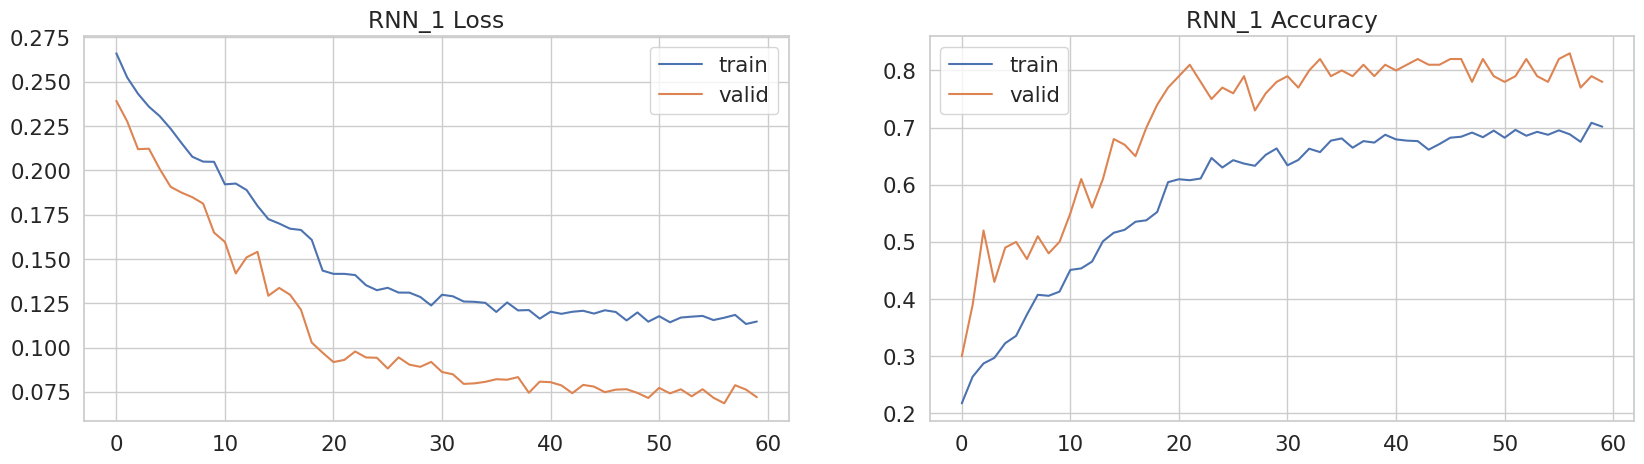

Accuracy test RNN_1: 0.78


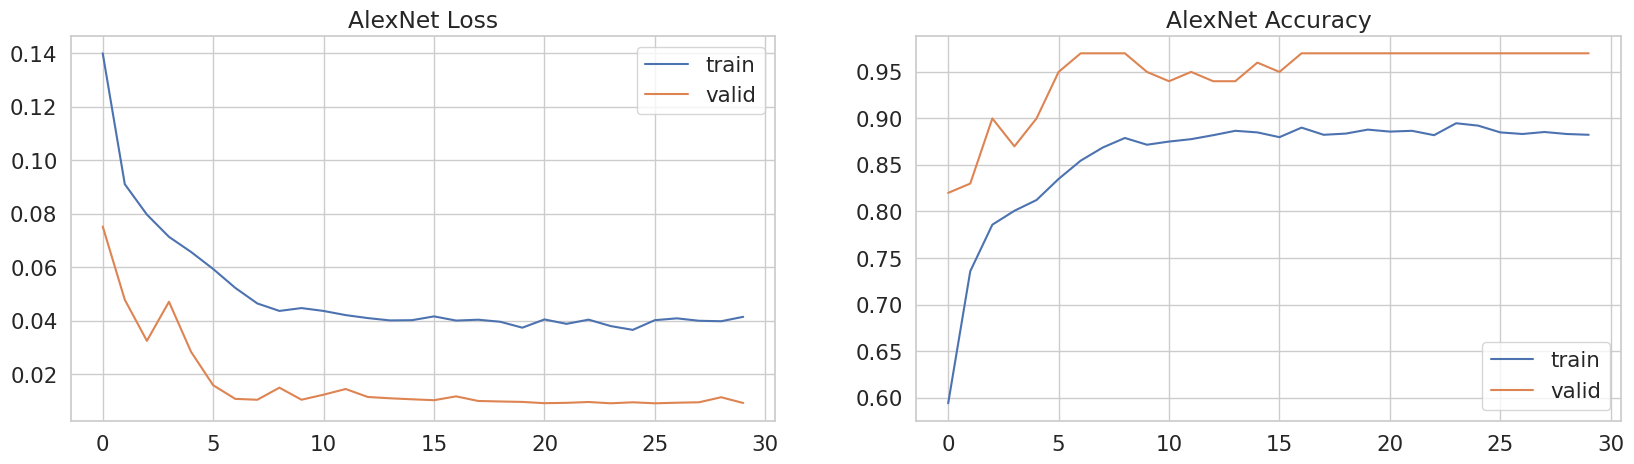

Accuracy test AlexNet: 0.97


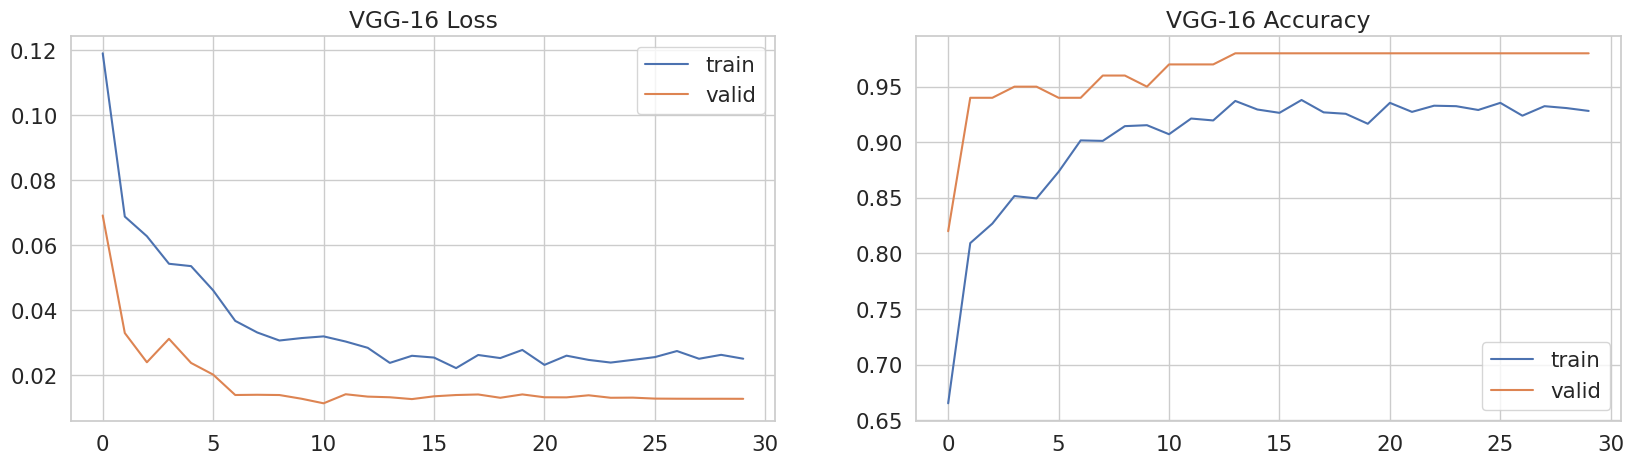

Accuracy test VGG-16: 0.98


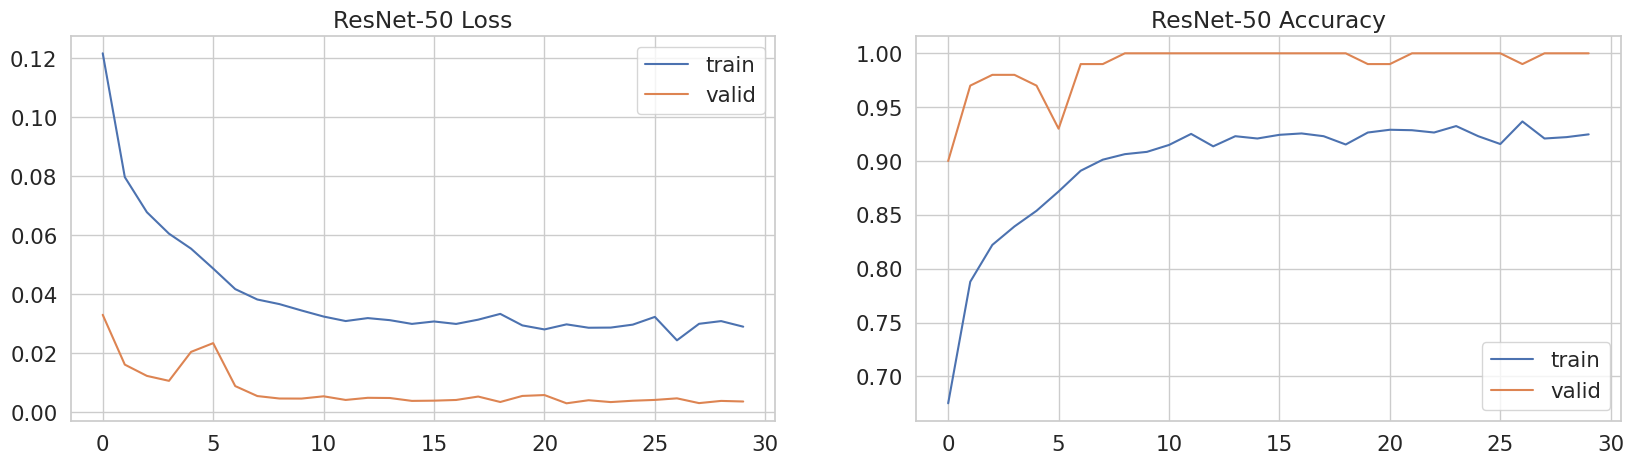

Accuracy test ResNet-50: 1.0


In [39]:
for i in arr:
    sns.set(style='whitegrid', font_scale=1.4)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.title(f'{i["name"]} Loss')
    plt.plot(i['losses']['train'], label='train')
    plt.plot(i['losses']['valid'], label='valid')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f'{i["name"]} Accuracy')
    plt.plot(i['accuracy']['train'], label='train')
    plt.plot(i['accuracy']['valid'], label='valid')
    plt.legend()

    plt.show()

    print(f'Accuracy test {i["name"]}: {round(train.evaluate(i["model"], dataloaders["valid"], device, dataset_sizes["valid"]), 4)}')

# Example

In [32]:
def view_predict(model, path, max_len=50):
    data_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(244),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    dataset_test = datasets.ImageFolder(os.path.join(path), data_transforms)

    model.eval()

    if max_len > len(dataset_test):
        len_dataset = len(dataset_test)
    else:
        len_dataset = max_len

    groups = round(len_dataset / 5)
    sns.set(style='white', font_scale=1)

    for i in range(groups):
        if len_dataset >= 5:
            remains = 5
        else:
            remains = len_dataset

        plt.figure(figsize=(20, 3))
        for j in range(remains):
            predict = class_names[torch.argmax(model_resnet(dataset_test[i*5 + j][0].reshape((1, 3, 244, 244)).to(device)))]
            y = class_names[dataset_test[i*5 + j][1]]
            label = f'Label: {y}\nPredict: {predict}'
            inp = dataset_test[i*5 + j][0].numpy().transpose((1, 2, 0))
            mean = np.array(([0.485, 0.456, 0.406]))
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.subplot(1, 5, j+1)
            plt.title(label)
            plt.axis("off")
            plt.imshow(inp)

        len_dataset -= remains

        plt.show()

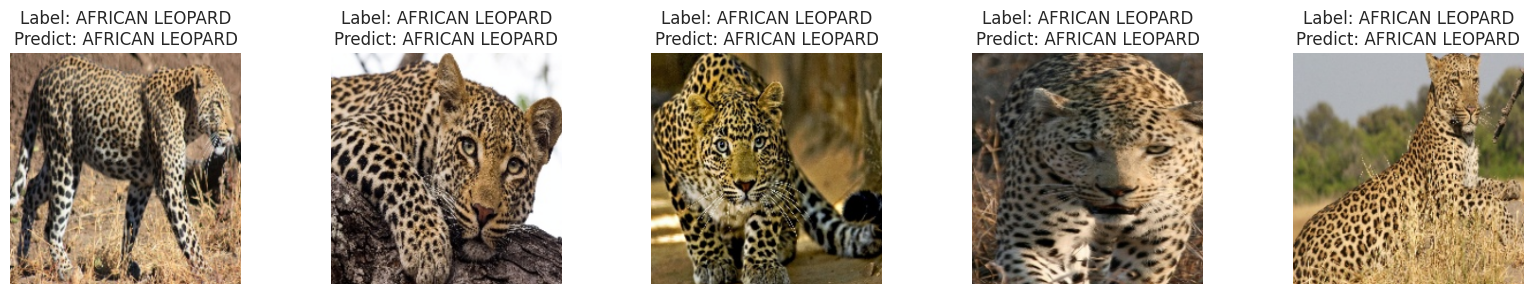

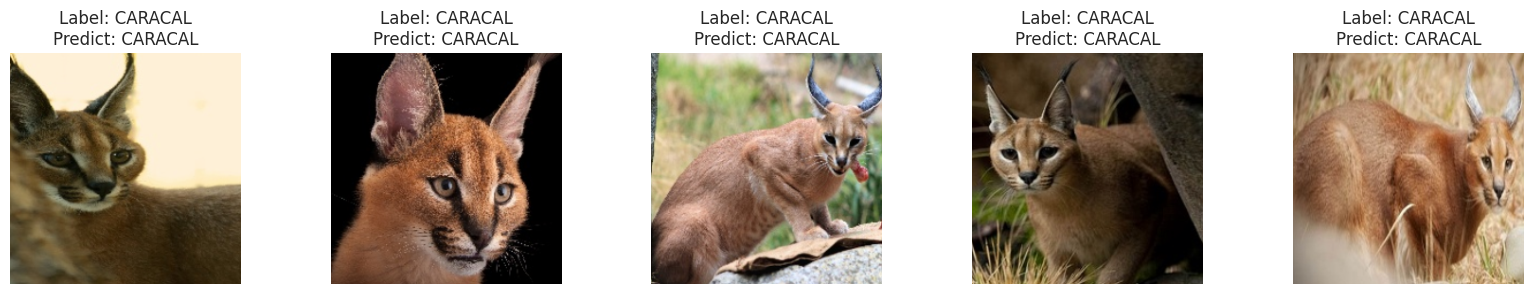

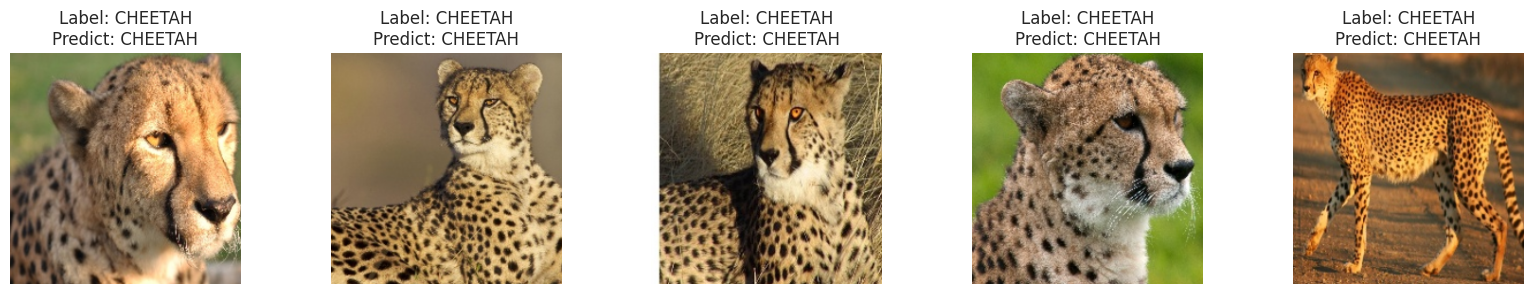

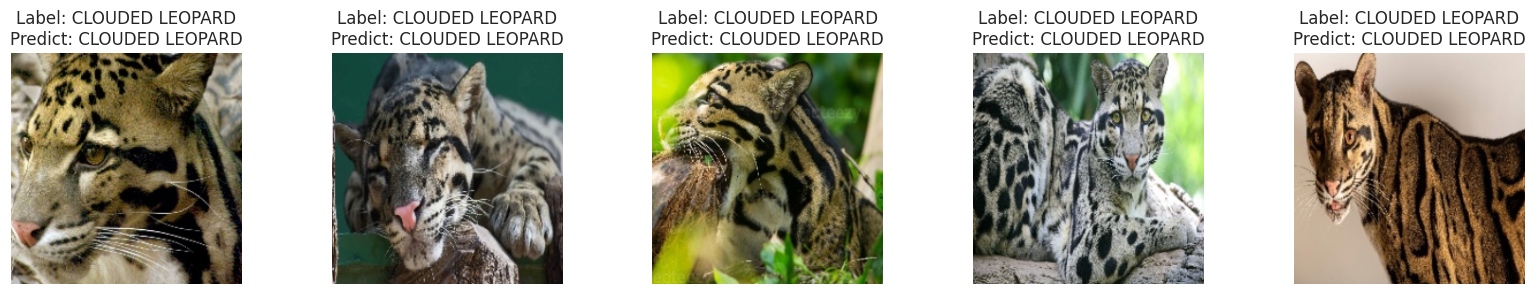

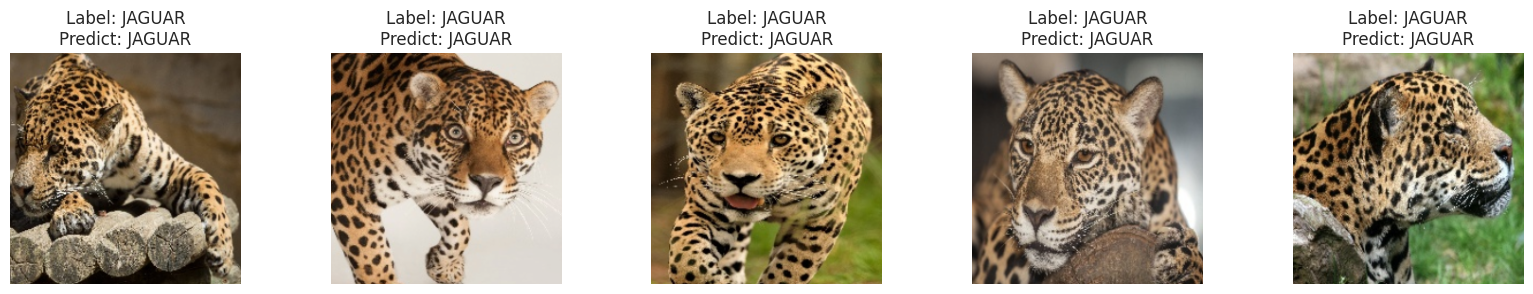

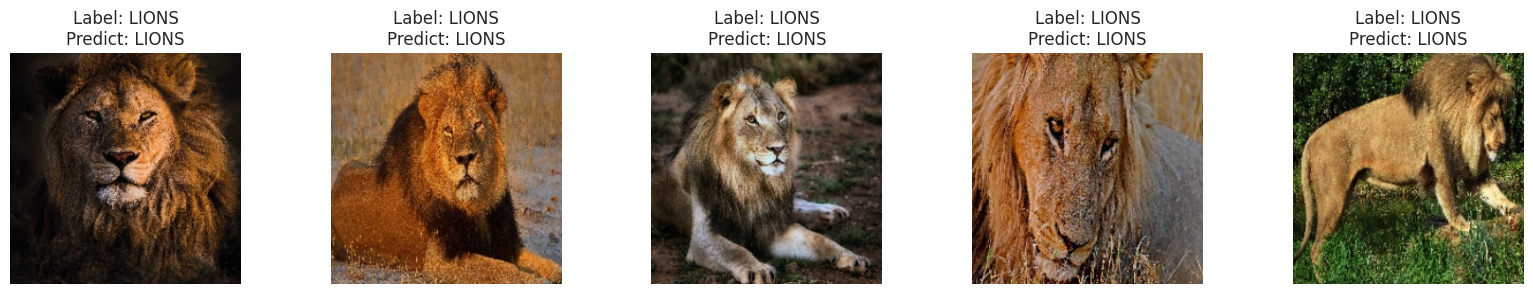

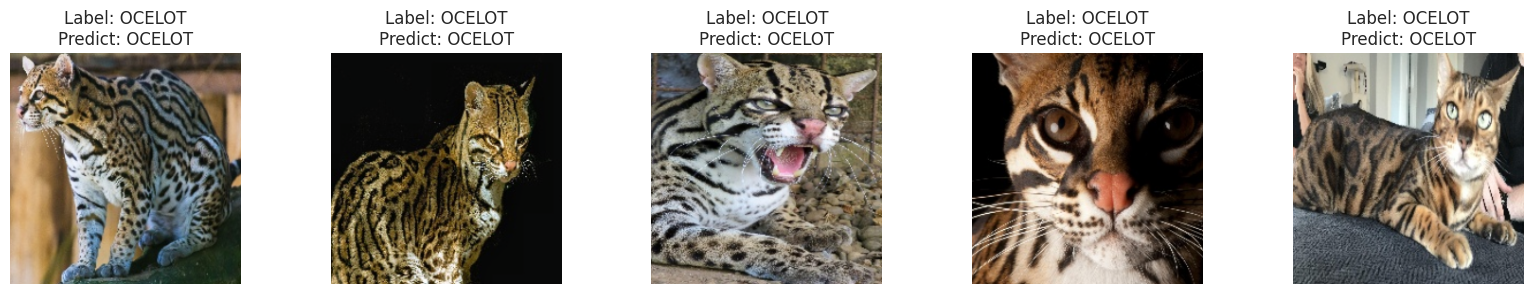

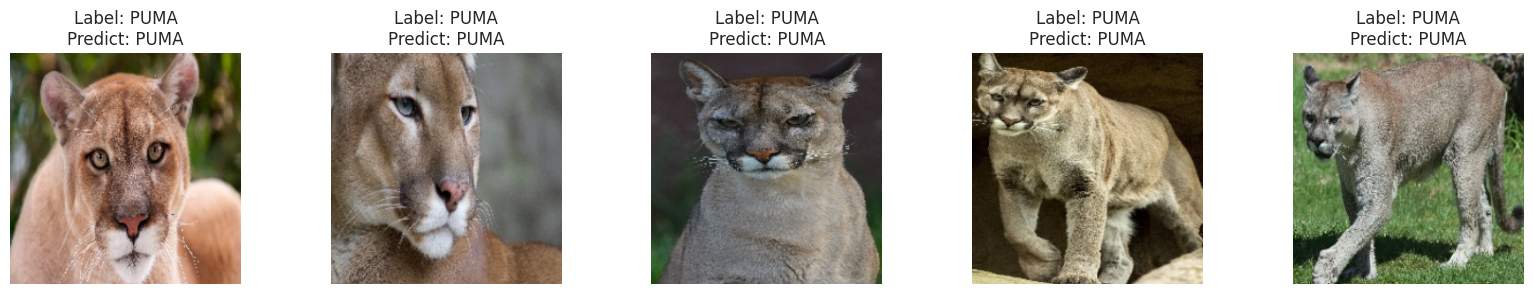

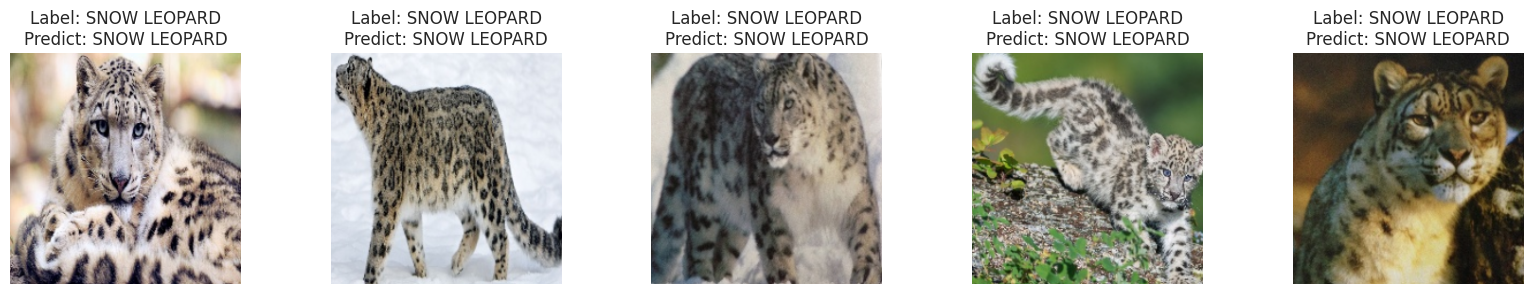

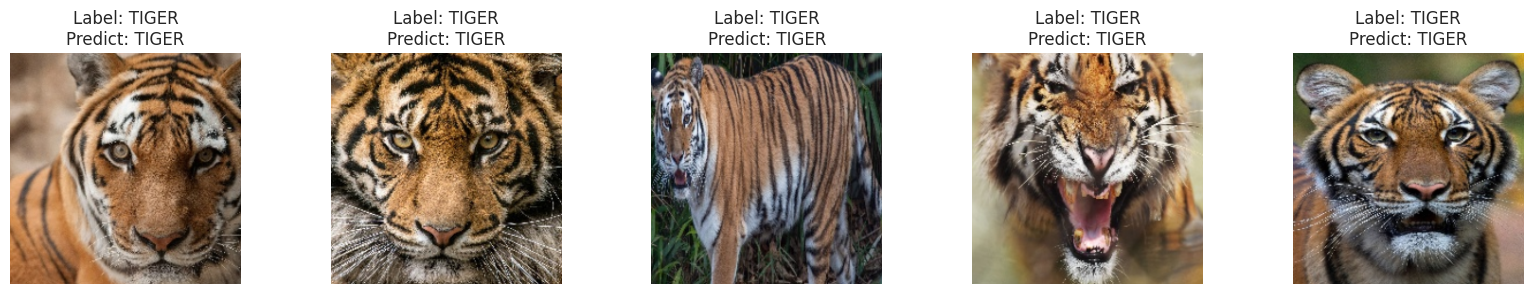

In [33]:
view_predict(model_resnet, 'files/dif_cats/test')